# Project: Investigate a Dataset (Medical Appointment No Shows)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction
From a dataset, we try to find the possible causes of patients not showing up for their medical appointments

### Libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

In [2]:
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')

In [3]:
df.shape

(110527, 14)

In [4]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


We have 110527 rows of patient visits and the last column 'No-show' is the dependent variable

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


No columns seem to have missing values.

We rename the columns with shorter lower-case names:

In [6]:
labels = ['patient_id', 'appoint_id', 'gender', 'sched_day', 'appoint_day', 'age', 'nbrhood' , 'scholar', 'htn' , 'diabetes', 'alch' , 'handicap', 'sms', 'show'] 
df.columns = labels

### Data Cleaning (column by column):

We start with the column of the dependent variable -> 'show':

In [7]:
print(df['show'].unique())

['No' 'Yes']


We changed the name of the column from 'No-show' to 'show' to make it less confusing, and so we have to change the column values accordingly and we also change them to numerical values:

In [8]:
df['show'] = df['show'].map({'No': 1, 'Yes': 0})

Check if the dataset contains any duplicate rows:

In [9]:
sum(df.duplicated())

0

The dataset contains no duplicate rows

### 1. patient_id


In [10]:
sum(df['patient_id'].duplicated())

48228

Of all the 110527 visits, 48228 were made by patients who had visits before

### 2. appoint_id

In [11]:
sum(df['appoint_id'].duplicated())

0

Each visit has its unique id.

### 3. gender

In [12]:
print(df['gender'].unique())

['F' 'M']


Patients include both males and females.

### 4. sched_day and appoint_day

We change the data type of sheduled day and appointment day to datetime:

In [13]:
df['sched_day'] = pd.to_datetime(df['sched_day'])
df['appoint_day'] = pd.to_datetime(df['appoint_day'])

Scheduled day is the day the patient registered for an appointment so appointment day always comes after scheduled day.
We check if that is true:

In [14]:
df[df['sched_day'] > df['appoint_day']].shape

(38568, 14)

There seems to be 38568 visits where scheduled day is after appointment day. It must be a mistake.

Since there are many columns other than the date columns representing other independent variables, we shouldn't drop these rows. <br>  We correct the mistake by assuming that scheduling and appointment occur on the same day:

In [15]:
df['sched_day'] = np.where(df['sched_day'] > df['appoint_day'], df['appoint_day'], df['sched_day'])

We create a new column of the waiting time between scheduling and appointment:

In [16]:
df['waiting_days'] = (df['appoint_day'] - df['sched_day']).dt.days

In [17]:
print(np.sort(df['waiting_days'].unique()))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 106 107 108 109 110
 111 114 116 118 121 122 124 125 126 131 132 138 141 145 150 154 161 168
 175 178]


We see that waiting time ranges from 0 days to nearly 3 months.

We create a new column of the hour of the appointment:

In [18]:
df['hour'] = df['appoint_day'].dt.hour

In [19]:
print(df['hour'].unique())

[0]


All appointments are registered at hour 0. So the 'hour' column is of no use.

We create a new column of the day of the appointment:

In [20]:
df['day_of_week'] = df['appoint_day'].dt.day_name()

In [21]:
print(df['day_of_week'].unique())

['Friday' 'Tuesday' 'Monday' 'Wednesday' 'Thursday' 'Saturday']


Visits are made throughtout the week except Sundays.

We create a new column of the month of the appointment:

In [22]:
df['month'] = df['appoint_day'].dt.month_name()

In [23]:
print(df['month'].unique())

['April' 'May' 'June']


The data includes visits that occurred during April, May and June. 

We no longer need the following columns anymore. So we drop them:

In [24]:
df.drop(['appoint_id','sched_day', 'appoint_day', 'hour'], axis = 1, inplace = True)

We check if there are duplicates after dropping the columns:

In [25]:
sum(df.duplicated())

6665

These rows represent repeated visists made by the same patients and had the same waiting_days, date_of_week, month and show status.

 We drop these rows to make the data cleaner and make it account more for the differences between the variables:

In [26]:
df.drop_duplicates(inplace = True)

In [27]:
df.shape

(103862, 14)

### 5. age

Change 'age' type from float to int:

In [28]:
df['age'].astype('int64');

In [29]:
print(np.sort(df['age'].unique()))

[ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 102 115]


We see that the age ranges from 0 (newborns) to 115 years. And there is the non-sensical age of -1.

In [30]:
df[df['age'] == -1]

,patient_id,gender,age,nbrhood,scholar,htn,diabetes,alch,handicap,sms,show,waiting_days,day_of_week,month
99832,4.659432e+14,F,-1,ROMÃO,0,0,0,0,0,0,1,0,Monday,June


Only one patient is registered with the age of -1. We look for possible other visits made by the same patient to check if the age was registered correctly someplace esle:

In [31]:
df[df['patient_id'] == 465943158731293]

,patient_id,gender,age,nbrhood,scholar,htn,diabetes,alch,handicap,sms,show,waiting_days,day_of_week,month
99832,4.659432e+14,F,-1,ROMÃO,0,0,0,0,0,0,1,0,Monday,June


Unfortunately, the patient made only one visit. Since it's only one row of data, we can drop it:

In [32]:
df.drop(99832 , axis = 0 , inplace = True)

In [33]:
df[df['age'] == -1].shape

(0, 14)

### 6. nbrhood

In [34]:
print(df['nbrhood'].unique())

['JARDIM DA PENHA' 'MATA DA PRAIA' 'PONTAL DE CAMBURI' 'REPÚBLICA'
 'GOIABEIRAS' 'ANDORINHAS' 'CONQUISTA' 'NOVA PALESTINA' 'DA PENHA'
 'TABUAZEIRO' 'BENTO FERREIRA' 'SÃO PEDRO' 'SANTA MARTHA' 'SÃO CRISTÓVÃO'
 'MARUÍPE' 'GRANDE VITÓRIA' 'SÃO BENEDITO' 'ILHA DAS CAIEIRAS'
 'SANTO ANDRÉ' 'SOLON BORGES' 'BONFIM' 'JARDIM CAMBURI' 'MARIA ORTIZ'
 'JABOUR' 'ANTÔNIO HONÓRIO' 'RESISTÊNCIA' 'ILHA DE SANTA MARIA'
 'JUCUTUQUARA' 'MONTE BELO' 'MÁRIO CYPRESTE' 'SANTO ANTÔNIO' 'BELA VISTA'
 'PRAIA DO SUÁ' 'SANTA HELENA' 'ITARARÉ' 'INHANGUETÁ' 'UNIVERSITÁRIO'
 'SÃO JOSÉ' 'REDENÇÃO' 'SANTA CLARA' 'CENTRO' 'PARQUE MOSCOSO' 'DO MOSCOSO'
 'SANTOS DUMONT' 'CARATOÍRA' 'ARIOVALDO FAVALESSA' 'ILHA DO FRADE'
 'GURIGICA' 'JOANA D´ARC' 'CONSOLAÇÃO' 'PRAIA DO CANTO' 'BOA VISTA'
 'MORADA DE CAMBURI' 'SANTA LUÍZA' 'SANTA LÚCIA' 'BARRO VERMELHO'
 'ESTRELINHA' 'FORTE SÃO JOÃO' 'FONTE GRANDE' 'ENSEADA DO SUÁ'
 'SANTOS REIS' 'PIEDADE' 'JESUS DE NAZARETH' 'SANTA TEREZA' 'CRUZAMENTO'
 'ILHA DO PRÍNCIPE' 'ROMÃO' 'COMDUSA' 

In [35]:
df['nbrhood'].nunique()

81

Patients come from 81 different neighbourhoods.

### 7. scholar

In [36]:
print(df['scholar'].unique())

[0 1]


The patient is either registered in the scholarship program or not.

### 8. htn

In [37]:
print(df['htn'].unique())

[1 0]


The patient either has hypertension or not.

### 9. diabetes

In [38]:
print(df['diabetes'].unique())

[0 1]


The patient either has diabetes or not.

### 10. alch

In [39]:
print(df['alch'].unique())

[0 1]


The patient is either alcoholic or not.

### 11. handicap

In [40]:
print(df['handicap'].unique())

[0 1 2 3 4]


The patient is either handicapped or not. And there seems to be 4 degrees of handicapping.

### 12. sms

In [41]:
print(df['sms'].unique())

[0 1]


The patient either received a reminder sms or not.

<a id='eda'></a>
## Exploratory Data Analysis


In [42]:
df.shape

(103861, 14)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103861 entries, 0 to 110526
Data columns (total 14 columns):
patient_id      103861 non-null float64
gender          103861 non-null object
age             103861 non-null int64
nbrhood         103861 non-null object
scholar         103861 non-null int64
htn             103861 non-null int64
diabetes        103861 non-null int64
alch            103861 non-null int64
handicap        103861 non-null int64
sms             103861 non-null int64
show            103861 non-null int64
waiting_days    103861 non-null int64
day_of_week     103861 non-null object
month           103861 non-null object
dtypes: float64(1), int64(9), object(4)
memory usage: 11.9+ MB


In [44]:
df.iloc[:,1:].describe()

,age,scholar,htn,diabetes,alch,handicap,sms,show,waiting_days
count,103861.000000,103861.000000,103861.000000,103861.000000,103861.000000,103861.000000,103861.000000,103861.000000,103861.000000
mean,37.064789,0.098131,0.199006,0.072828,0.027200,0.021606,0.339040,0.792935,9.942385
std,23.176724,0.297493,0.399255,0.259855,0.162666,0.159479,0.473386,0.405205,15.263076
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000
75%,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,14.000000
max,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,178.000000


The mean patient age is about 37 years.<br> 
More than 75% of patients don't have scholarships.<br>  More than 75% of patients don't suffer from hypertension. <br>
More than 75% of patients don't suffer from diabetes. <br>More than 75% of patients don't suffer from  alcholism. <br> More than 75% of patients don't suffer from handicapping.<br>  More than 50% of patients didn't receive sms.<br>  More than 75% of patients showed up for the visit.<br>  Average number of waiting days is about 10 days.<br>  

We divide the dataframe into 2 groups. Those who showed up and those who didn't:

In [45]:
df_show = df[df['show'] == 1]
df_noshow = df[df['show'] == 0]

In [46]:
total = df.shape[0]
show = df_show.shape[0]
noshow = df_noshow.shape[0]

Percentage of patients that didn't show up:

In [47]:
print ('{}%'.format(round(noshow/total * 100,2)))

20.71%


20.71% of patients didn't show up. We try to find the possible causes by asking the following questions:

### Research Question 1 (Does gender affect showing up?)

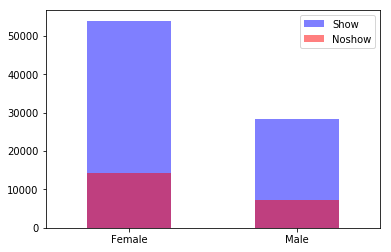

In [48]:
df_show['gender'].value_counts().plot( kind='bar', label = 'Show', color = 'blue', alpha = 0.5)
df_noshow['gender'].value_counts().plot( kind='bar', label = 'Noshow', color = 'red', alpha = 0.5)
plt.xticks( [0,1], ['Female', 'Male'], rotation = 'horizontal')
plt.legend();

The majority of patients are females.<br>  However the percentage of patients not showing up doesn't seem to differ much with respect to the gender.<br>  We confirm this observation by numbers:<br> 

In [49]:
#Function to return percentage of patients within a particular group having some variable equal some value
def percentage (df_group, df , variable, value):
    return ('{}%'.format(round(df_group[df_group[variable] == value][variable].count()/df[df[variable] == value][variable].count() * 100,2)))

Percentage of patients not showing up among males:

In [50]:
print(percentage (df_noshow, df, 'gender' , 'M'))

20.52%


Percentage of patients not showing up among females:

In [51]:
print(percentage (df_noshow, df, 'gender' , 'F'))

20.8%


As we can see, the percentages are very close.

### Research Question 2 (Does age affect showing up?)

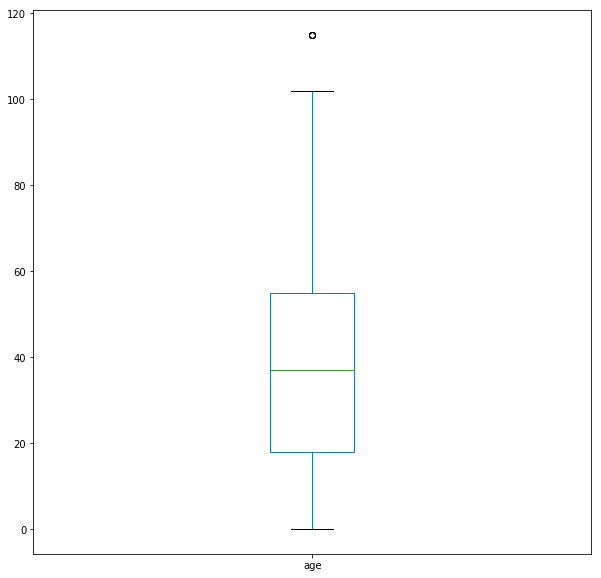

In [52]:
df['age'].plot(kind = 'box', figsize = (10,10));

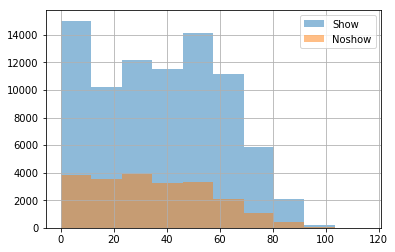

In [53]:
df_show['age'].hist( alpha = 0.5, label = 'Show')
df_noshow['age'].hist( alpha = 0.5, label = 'Noshow')
plt.legend();

As we can see, the majority of patients are newborns and kids. There is a peak around the age of 50 years.<br> There is an age outlier at 115 years.<br>
The percentage of patients not showing up doesn't seem to differ much among different age groups. 

We confirm this observation by calculating the correlation coefficient:

In [54]:
print(round(np.corrcoef(df['age'], df['show'])[0, 1],2))

0.06


We find it's very close to zero.

### Research Question 3 (Does the Neighbourhood affect showing up?)

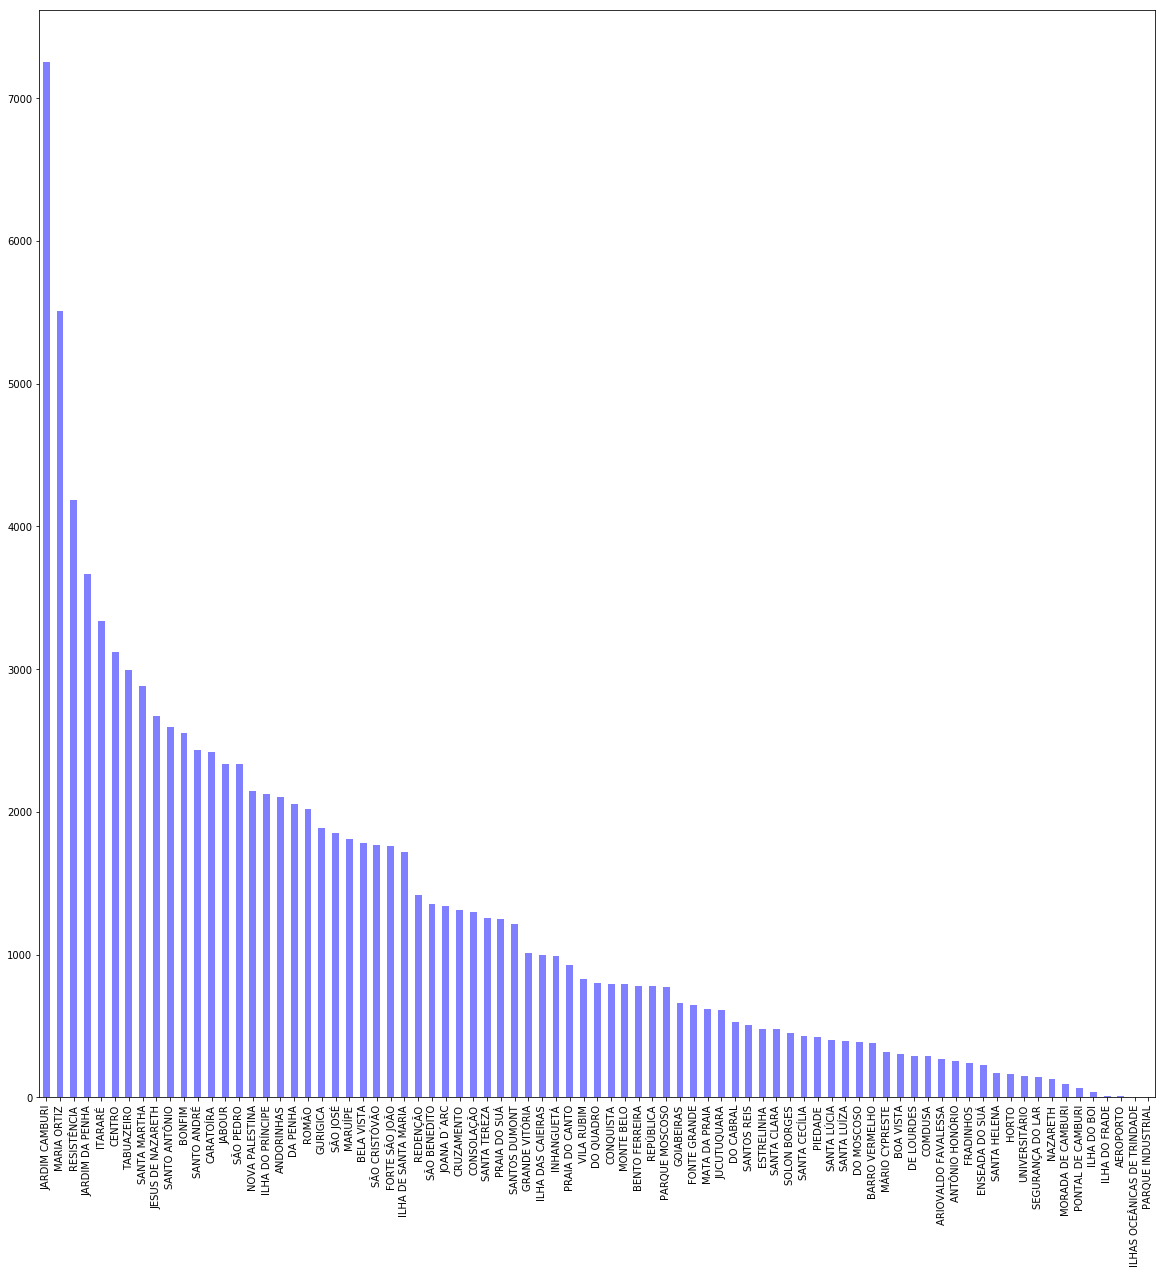

In [55]:
df['nbrhood'].value_counts().plot( kind = 'bar', figsize = (20,20), color = 'blue', alpha = 0.5);

We see that the number of patients differs greatly among different neighbourhoods with 'JARDIM CAMBURI' having more than 7000 patients and 'PARQUE INDUSTRIAL' having a little higher than zero patients. This might be due to several factors such as different neighbourhood populations, social level, education level, distance from healthcare facilities, etc. The dataframe doesn't provide much to study such factors.

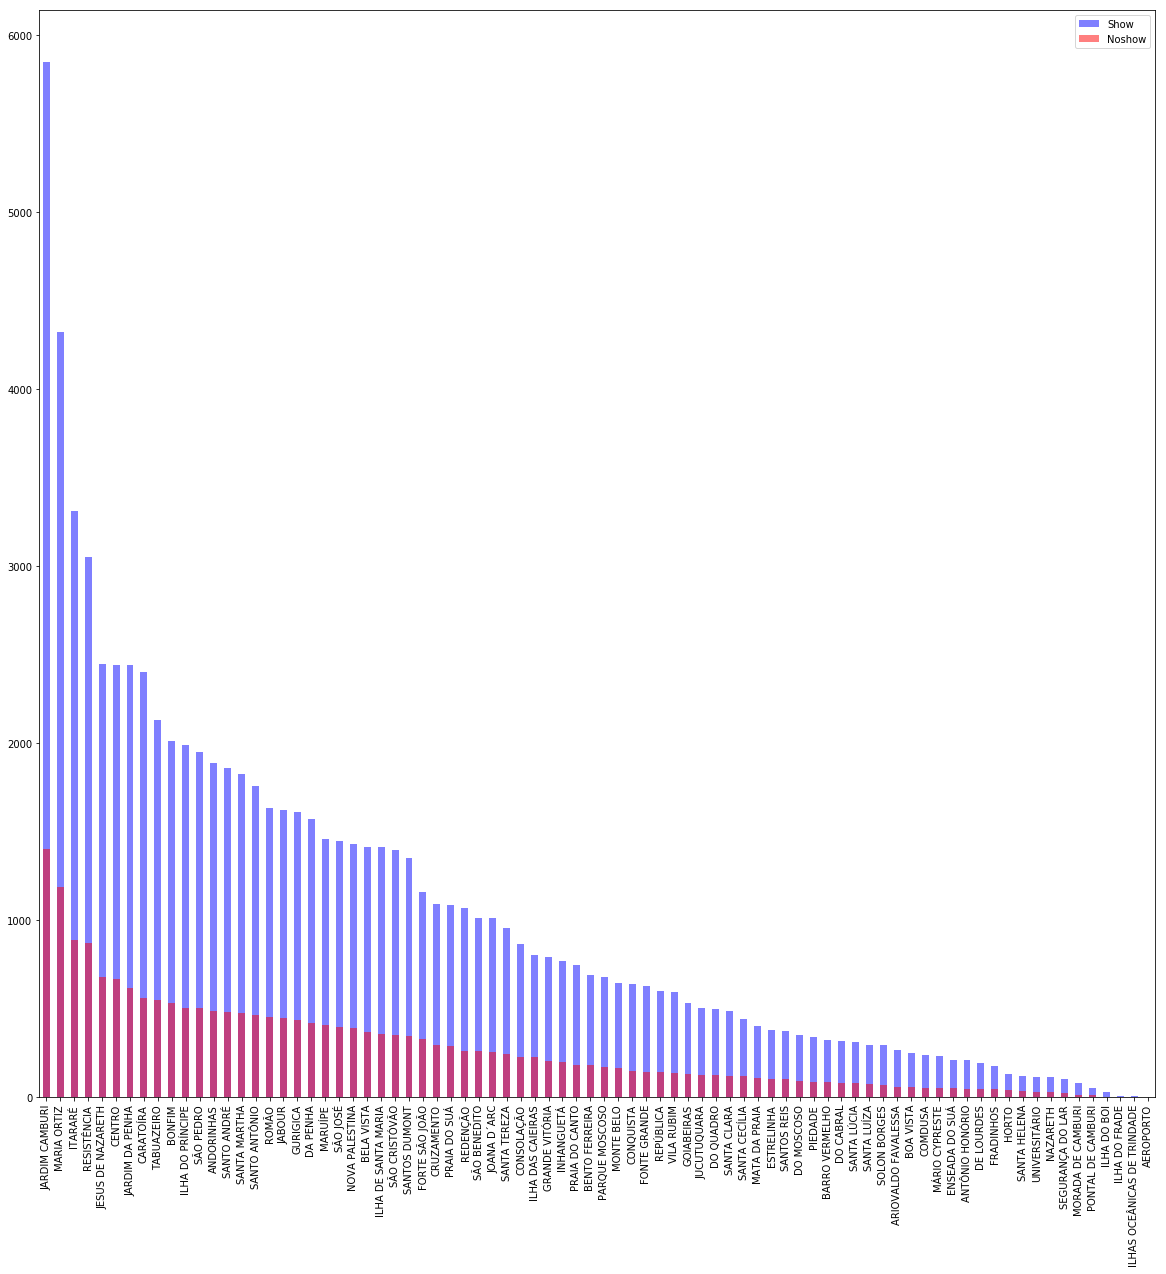

In [56]:
df_show['nbrhood'].value_counts().plot( kind='bar', figsize = (20,20), label = 'Show', color = 'blue', alpha = 0.5)
df_noshow['nbrhood'].value_counts().plot( kind='bar', figsize = (20,20), label = 'Noshow', color= 'red', alpha = 0.5)
plt.legend();

Although very differnt in the number of patient visits, We see that the percentage of those not showing up doesn't seem to differ much among different neighbourhoods.

### Research Question 4  (Does having a scholarship affect showing up?)

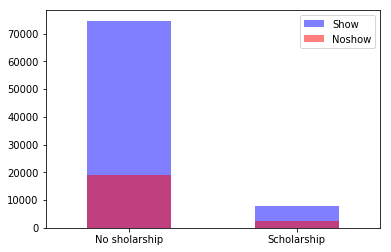

In [57]:
df_show['scholar'].value_counts().plot( kind='bar', label = 'Show', color = 'blue', alpha = 0.5)
df_noshow['scholar'].value_counts().plot( kind='bar' ,label = 'Noshow', color= 'red', alpha = 0.5)
plt.xticks([0,1], ['No sholarship', 'Scholarship'], rotation = 'horizontal')
plt.legend();

The majority of patients don't have scholraships. The precentages of patients not showing up don't appear to differ by much. We confirm this observation by numbers: 

Percentage of patients not showing up among those that don't have a scholarship:

In [58]:
print(percentage (df_noshow, df, 'scholar' , 0))

20.33%


Percentage of patients not showing up among those that have a schorship:

In [59]:
print(percentage (df_noshow, df, 'scholar' , 1))

24.21%


The percentage is slightly higher among the patients having a scholarship. Having a scholarship might increase the possibility of the patient not showing up.

### Research Question 5  (Does having hypertension affect showing up?)

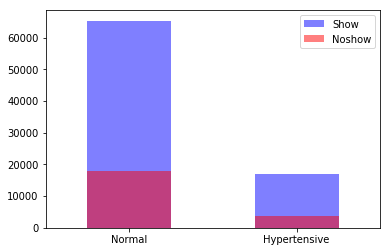

In [60]:
df_show['htn'].value_counts().plot( kind='bar', label = 'Show', color = 'blue', alpha = 0.5)
df_noshow['htn'].value_counts().plot( kind='bar', label = 'Noshow', color='red', alpha = 0.5)
plt.xticks([0,1],  ['Normal', 'Hypertensive'], rotation = 'horizontal')
plt.legend();

The majority of patients don't have hypertension. The precentages of patients not showing up don't appear to differ by much. We confirm this observation by numbers: 

Percentage of patients not showing up among those that don't have hypertension:

In [61]:
print(percentage (df_noshow, df, 'htn' , 0))

21.45%


Percentage of patients not showing up among those that have hypertension:

In [62]:
print(percentage (df_noshow, df, 'htn' , 1))

17.72%


The percentage is slightly lower among the patients having hypertension. Having hypertension might increase the possibility of the patient showing up.

### Research Question 6 (Is there a correlation between age and hypertension?)

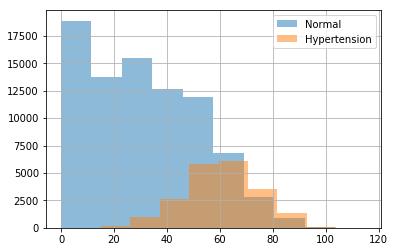

In [63]:
df[df['htn'] == 0]['age'].hist(alpha = 0.5, label = 'Normal')
df[df['htn'] == 1]['age'].hist(alpha = 0.5, label = 'Hypertension')
plt.legend();

As we can see, young patients don't suffer from hypertension. The percentage of patients having hypertension starts to increase gradually starting around the age of 30. At around the age of 70, the majority of patients have hypertension.

By calculating the correlation coefficient between age and hypertension:

In [64]:
print(round(np.corrcoef(df['age'],df['htn'])[0,1],1))

0.5


We find that there is a moderate positive correlation.

### Research Question 7 (Does having diabetes affect showing up?)

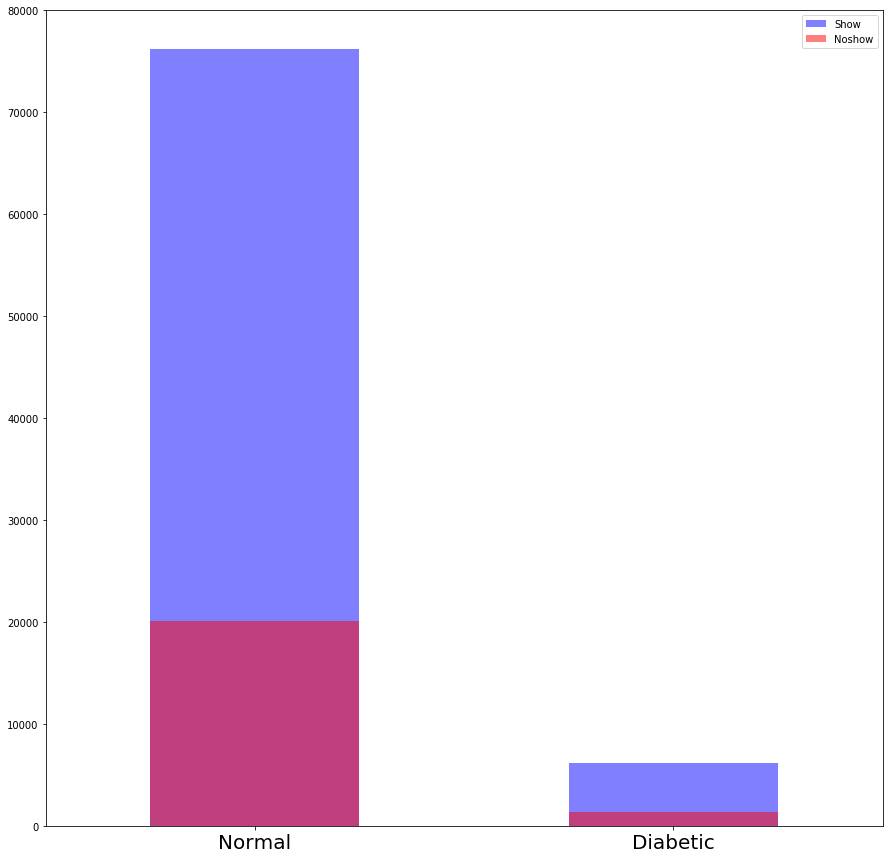

In [65]:
df_show['diabetes'].value_counts().plot( kind='bar', figsize = (15,15), label = 'Show', color = 'blue', alpha = 0.5)
df_noshow['diabetes'].value_counts().plot( kind='bar', figsize = (15,15), label = 'Noshow', color="red", alpha = 0.5)
plt.xticks( [0,1],  ['Normal', 'Diabetic'], rotation = 'horizontal', fontsize = 20)
plt.legend();

The majority of patients don't have diabetes. The precentages of patients not showing up don't appear to differ by much. We confirm this observation by numbers: 

Percentage of patients not showing up among those that don't have diabetes:

In [66]:
print(percentage (df_noshow, df, 'diabetes' , 0))

20.88%


Percentage of patients not showing up among those that have diabetes:

In [67]:
print(percentage (df_noshow, df, 'diabetes' , 1))

18.54%


The percentage is slightly lower among the patients having diabetes. Having diabetes might increase the possibility of the patient showing up.

### Research Question 8 (Is there a correlation between age and diabetes?)

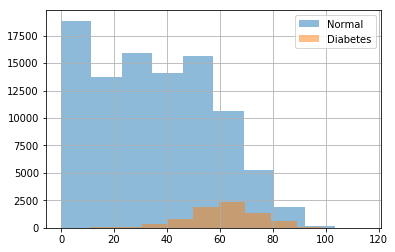

In [68]:
df[df['diabetes'] == 0]['age'].hist(alpha = 0.5, label = 'Normal')
df[df['diabetes'] == 1]['age'].hist(alpha = 0.5, label = 'Diabetes')
plt.legend();

As we can see, young patients don't suffer from diabetes. The percentage of patients having diabetes starts to increase gradually starting around the age of 30. There is a peak around the age of 60-70.

By calculating the correlation coefficient between age and diabetes:

In [69]:
print(round(np.corrcoef(df['age'],df['diabetes'])[0,1],1))

0.3


We find that there is a mild positive correlation.

### Research Question 9 (Does alcholism affect showing up?)

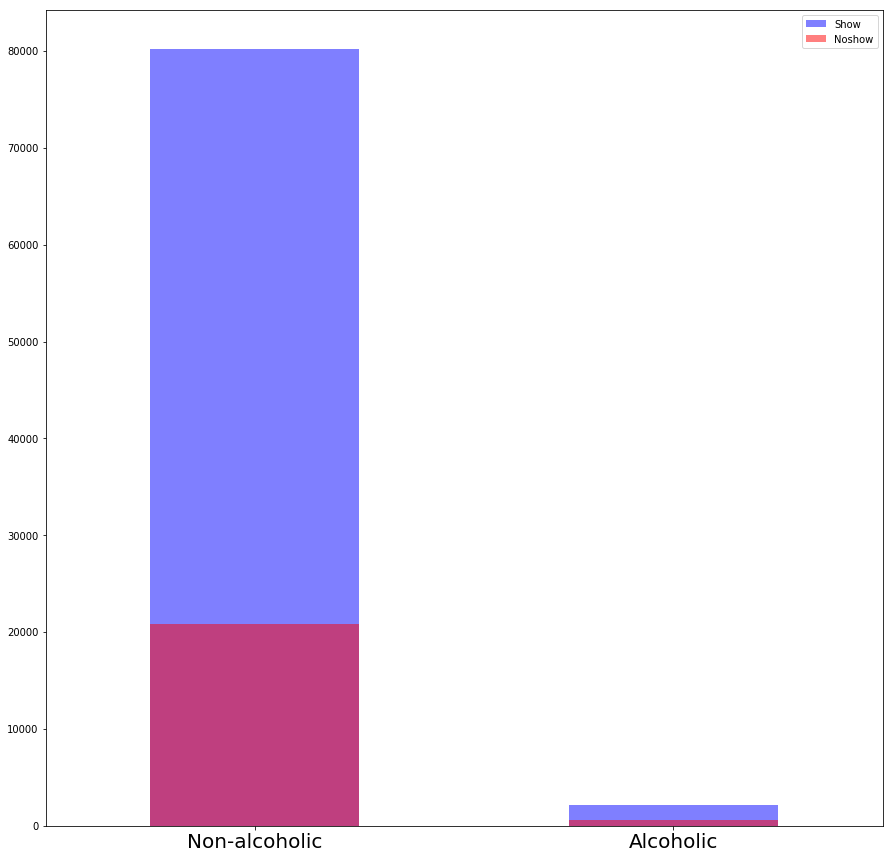

In [70]:
df_show['alch'].value_counts().plot( kind='bar', figsize = (15,15), label = 'Show', color = 'blue', alpha = 0.5)
df_noshow['alch'].value_counts().plot( kind='bar', figsize = (15,15), label = 'Noshow', color="red", alpha = 0.5)
plt.xticks( [0,1],  ['Non-alcoholic', 'Alcoholic'], rotation = 'horizontal', fontsize = 20)
plt.legend();

The majority of patients are not alcoholic. The precentages of patients not showing up don't appear to differ by much. We confirm this observation by numbers:

Percentage of patients not showing up among non-alcoholic patients:

In [71]:
print('{}%'.format(percentage (df_noshow, df, 'alch' , 0),2))

20.64%%


Percentage of patients not showing up among alcoholic patients:

In [72]:
print(percentage (df_noshow, df, 'alch' , 1))

23.01%


The percentage is slightly higher among alcoholic patients. Alcoholism might decrease the possibility of the patient showing up.

### Research Question 10 (Does being a handicap affect showing up?)

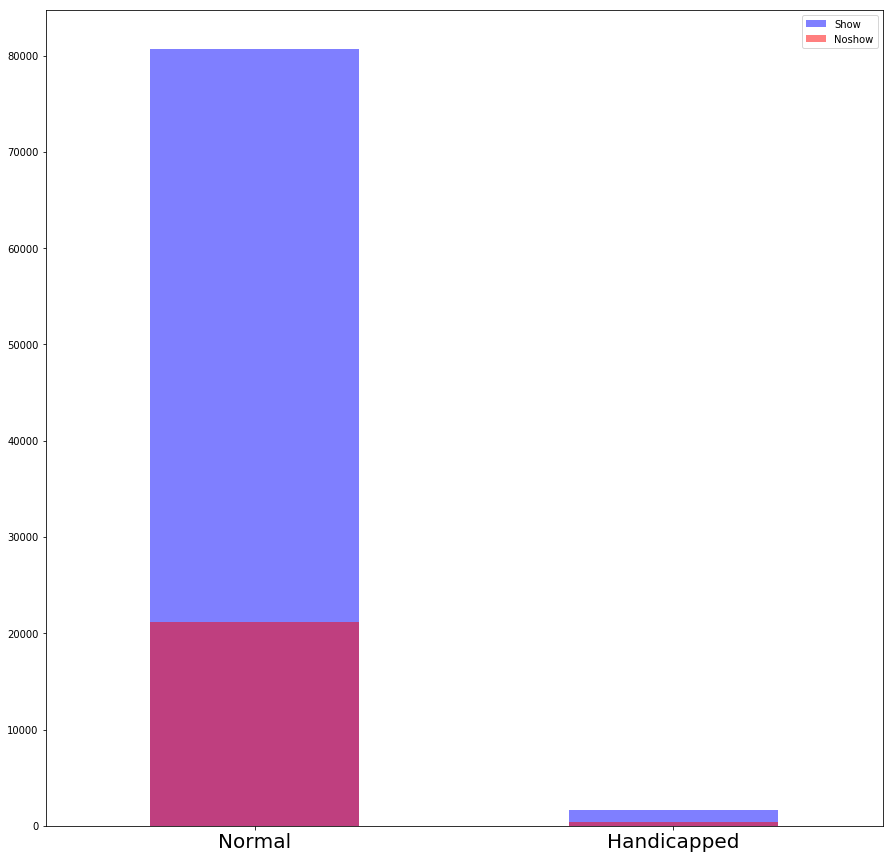

In [73]:
df_show['handicap'].astype('bool').value_counts().plot( kind='bar', figsize = (15,15), label = 'Show' , color = 'blue', alpha = 0.5)
df_noshow['handicap'].astype('bool').value_counts().plot( kind='bar', figsize = (15,15), label = 'Noshow', color="red", alpha = 0.5)
plt.xticks( [0,1],  ['Normal', 'Handicapped'], rotation = 'horizontal', fontsize = 20)
plt.legend();

 The majority of patients are not handicapped. The precentages of patients not showing up don't appear to differ by much. We confirm this observation by numbers:

Percentage of patients not showing up among those that are not handicapped:

In [74]:
print(percentage (df_noshow, df, 'handicap' , 0))

20.77%


Percentage of patients not showing up among those that are handicapped:

In [75]:
print('{}%'.format(round(df_noshow[df_noshow['handicap'] >= 1]['handicap'].count()/df[df['handicap'] >= 1]['handicap'].count() * 100,2)))

17.64%


The percentage is slightly lower among handicapped patients. But there are 4 different degrees of handicapping. Is this percentage equal among the different degrees?

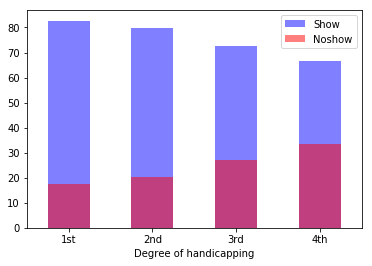

In [76]:
(df_show[df_show['handicap'] >= 1]['handicap'].value_counts()/df[df['handicap'] >= 1]['handicap'].value_counts() * 100).plot(kind = 'bar', label = 'Show', color = 'blue', alpha = 0.5)
(df_noshow[df_noshow['handicap'] >= 1]['handicap'].value_counts()/df[df['handicap'] >= 1]['handicap'].value_counts() * 100).plot(kind = 'bar', label = 'Noshow', color="red", alpha = 0.5)
plt.xticks ( [0,1,2,3],  ['1st', '2nd', '3rd', '4th'] ,rotation = 'horizontal')
plt.xlabel('Degree of handicapping')
plt.legend();

We see that as the degree of handicapping increases, the number of patients decreases but the percentage of those not showing up increases.

In [77]:
print(df_noshow[df_noshow['handicap'] >= 1]['handicap'].value_counts()/df[df['handicap'] >= 1]['handicap'].value_counts() * 100)

1    17.304582
2    20.348837
3    27.272727
4    33.333333
Name: handicap, dtype: float64


Only patients with first-degree handicapping have lower percentage of not showing up than normal patients. So having a first degree handicapping might increase the posibility of the patient showing up. <br>
Patients with second-degree handicapping have nearly equal percentage of not showing up as the normal patients. So having a second-degree handicapping might not affect the possibility of the patient showing up. <br>
Patients with third and forth degree handicapping have considerable higher percentage of not showing up than normal patients. About 1/3 of patients with forth degree handicapping didn't show up. So, having 3rd and 4th degree handicapping might strongly decrease the possibility of the patient not showing up.

### Research Question 11 (Does receiving a reminder SMS affect showing up?)

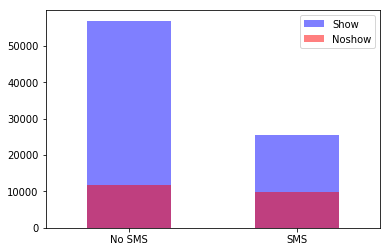

In [78]:
df_show['sms'].value_counts().plot( kind='bar', label = 'Show', color ='blue', alpha = 0.5)
df_noshow['sms'].value_counts().plot( kind='bar', label = 'Noshow', color= 'red', alpha = 0.5)
plt.xticks( [0,1], ['No SMS', 'SMS'], rotation = 'horizontal')
plt.legend();

The majority of patients didn't receive a reminder sms.<br> Surprisingly, The precentage of patients not showing up appears to be higher among patients who received an SMS.

Percentage of patients not showing up among those who didn't receive a reminder sms:

In [79]:
print(percentage (df_noshow, df, 'sms' , 0))

17.11%


Percentage of patients not showing up among those who received a reminder sms:

In [80]:
print(percentage (df_noshow, df, 'sms' , 1))

27.71%


The percentage is much higher among pateints who received an SMS. This is counter-intuitive, as receiving a reminder is supposed to increase the number of patients showing up. <br>Further investigation is needed. May be the data is wrong or the sms were not sent at all.

### Research Question 12 (Does the number of waiting days affect showing up?)

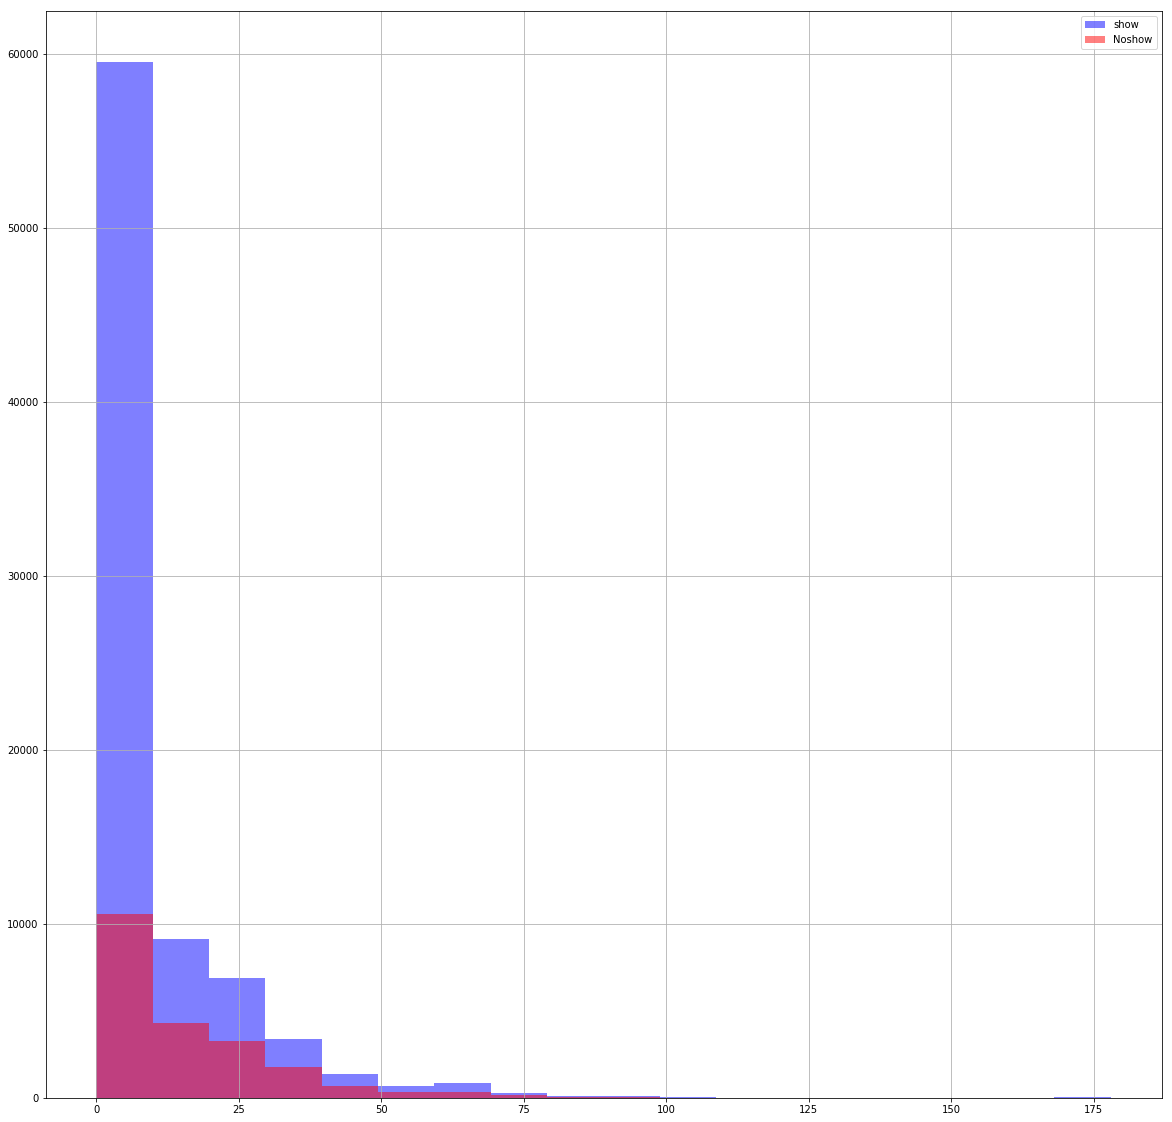

In [81]:
df_show['waiting_days'].hist(bins = 18, figsize =(20,20), label = 'show', color = 'blue', alpha = 0.5)
df_noshow['waiting_days'].hist( bins = 18, figsize =(20,20), label = 'Noshow', color="red", alpha = 0.5)
plt.legend();

As we can see, <br> 
At waiting days less than 10, the percentage of patients not showing up is low (around 10/70). <br> 
At waiting-days more than 10, the percentage of patients not showing up is higher (almost 1/3).<br>
We confirm this observation by numbers:

Percentage of patients not showing up if the number of waiting days is equal to or less than 10:

In [82]:
print('{}%'.format(round(df_noshow[df_noshow['waiting_days'] <= 10]['waiting_days'].count()/df[df['waiting_days'] <= 10]['waiting_days'].count() * 100,2)))

15.31%


Percentage of patients not showing up if the number of waiting days is more than 10:

In [83]:
print('{}%'.format(round(df_noshow[df_noshow['waiting_days'] > 10]['waiting_days'].count()/df[df['waiting_days'] > 10]['waiting_days'].count() * 100,2)))

32.38%


The percentage is much higher if the number of waiting days is more than 10. Having to wait more than 10 days might strongly decrease the possibility of the patient showing up. <br> We should bear in mind that we had assumed earlier that 38568 visits where the scheduled day was mistakenly registered after the appointment day had a waiting time of 0 days. <br>
Though the show status might differ among these visits, further investigation and data collection is needed to confirm the results.

### Research Question 13 (Does the day of the appointment affect showing up?)

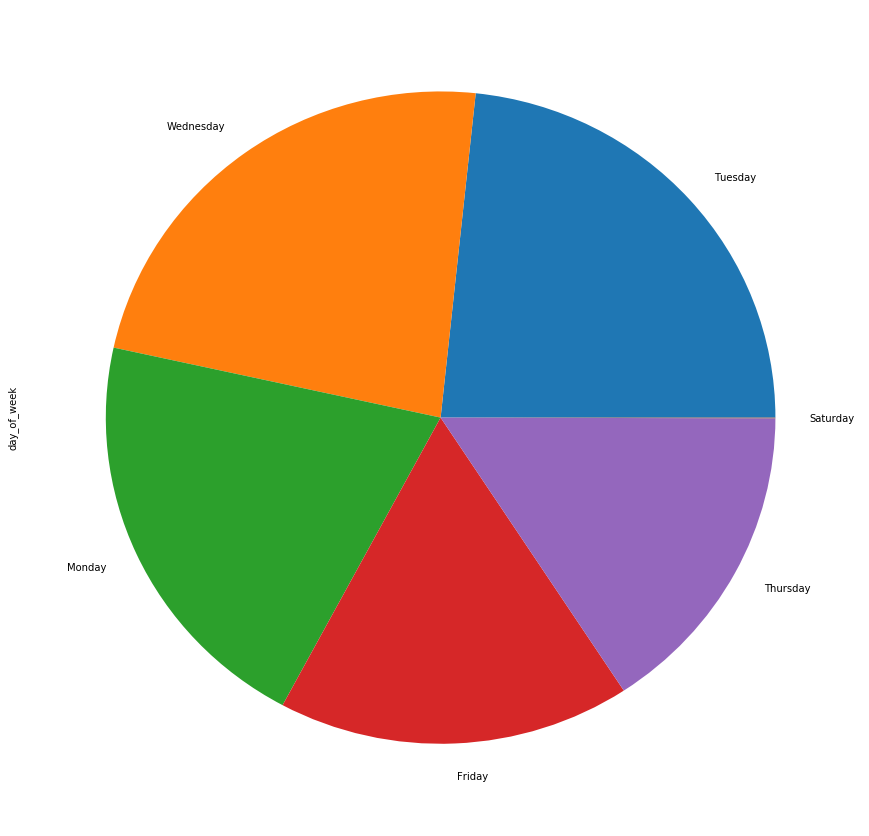

In [84]:
df['day_of_week'].value_counts().plot(kind = 'pie', figsize = (15,15));

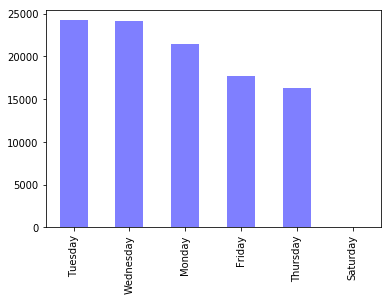

In [85]:
df['day_of_week'].value_counts().plot(kind = 'bar', color ='blue', alpha = 0.5);

In [86]:
df[df['day_of_week'] == 'Saturday'].shape

(39, 14)

Only 39 patients had their visits on Saturdays.

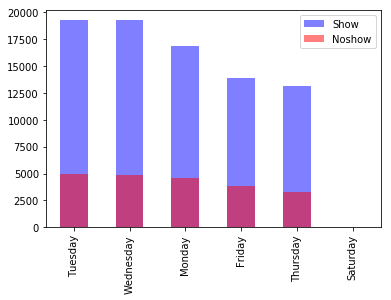

In [87]:
df_show['day_of_week'].value_counts().plot( kind='bar', label = 'Show', color = 'blue', alpha = 0.5)
df_noshow['day_of_week'].value_counts().plot( kind='bar', label = 'Noshow', color = 'red', alpha = 0.5)
plt.legend();

Although very differnt in the number of patient visits, We see that the percentage of those not showing up doesn't seem to differ much with respect to the day of the week. <br>We confirm this observation by numbers:

In [88]:
print(df_noshow['day_of_week'].value_counts()/df['day_of_week'].value_counts() * 100)

Tuesday      20.554730
Wednesday    20.209724
Monday       21.362533
Friday       21.598101
Thursday     19.834913
Saturday     23.076923
Name: day_of_week, dtype: float64


Except for Saturday which has very low number of patient visits, the percentage of patients not showing up is very close among different days of the week. 


# Conclusions

## We find that many factors seem to affect the possibility of patients showing up for their medical appointments. <br>
### Factors that might have a strong effect include: <br> 
 -Number of waiting days between scheduled day and appointment day (the longer the wait, the less the liklihood of showing up) <br>
 -Having 3rd or 4th degree handicapping (seems to strongly decrease the possibility of showing up) <br>
 -Receiving a reminder SMS. (Strangely seems to decrease the possibility of showing up) <br>
### Factors that might have a moderate effect include: <br>
 -Having hypertension. (seems to slightly increase the possibility of showing up) <br>
 -Having diabetes. (seems to slightly increase the possibility of showing up) <br>
 -Being regestered in the scholarship program. (seems to slightly decrease the possibility of showing up) <br>
 -Being alcoholic. (seems to slightly decrease the possibility of showing up) <br>
 -Having 1st degree handicapping. (seems to slightly increase the possibility of showing up) <br>
 
### Factors that don't seem to affect the possibility of patients showing up for their medical appointments include: <br>
 -Gender <br>
 -Age <br>
 -Neighbourhood <br>
 -Having 2nd degree handicapping <br>



# Further investigation is needed to confirm these conclusions.